# El Farol Bar Problem
Payam Mousavi  
Last Updated: February 14, 2021  

In [1]:
%matplotlib inline
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import random
import collections
from tqdm import tqdm
matplotlib.rcParams.update({'font.size': 22})

In [11]:
class El_Farol_env:
    def __init__(self, num_agents = 100, m = 5, n = 20, thr = 60, seed=42):
        np.random.seed(seed)
        self.num_agents = num_agents # Number of agents
        self.M = m # Number of weeks to remember (memory)
        self.N = n # Number of strategies per agent
        self.THR = thr # Occupancy threshold
        
        assert self.num_agents > self.THR, "Number of agents must be larger than attendance threshold!"
        
        # Initialize random decision weights for all players
        self.weight_mat = np.random.uniform(-1, 1, (self.num_agents, self.N, self.M + 1))
        
        # Initialize 2*M random instances of weeks of attendance
        self.A_M = collections.deque(maxlen = 2*self.M)
        for i in range(2*self.M):
            self.A_M.append(np.random.randint(0, self.num_agents-1))
        
        # Initialize the current time step's attendance: 
        self.A_t = np.random.randint(0, self.num_agents-1)
    
    def make_decision(self, w_vec, A_vec, s_ind=None):
        '''
        Decision making for one agent:
         Inputs:
               w_vec: [N x M+1] - Initialized weight vectors (and bias) for one agent's strategies 
               A_vec: [2M x 1] - Attendance for the last 2*M steps (Cirular buffer)
               s_ind: Index {0,N} of the previous best decision strategy, if None, estimate based on memory
         Outputs:
               d: [False, True] ~ [DON'T GO, GO]
               S_guess: Scalar - Estimated number of attendees for current time step (mostly used for troubleshooting)
        '''
        S = np.zeros((self.N, self.M+1))
        E = np.zeros(self.N)
               
        if s_ind is None: # Initial time step
            # Select a random strategy on the initial step
            s_ind = np.random.choice(self.N)
        
        # No need to calculate the whole S matrix. Just calculating the required index:
        S_guess = np.dot(w_vec[s_ind,:-1], np.array(A_vec)[self.M:2*self.M]) + 100 * w_vec[s_ind,-1]
                   
        # Make Decision:
        if S_guess <= self.THR: 
            d = True # GO
        else: 
            d = False # DON'T GO
    
        return E, d, S_guess
         
    
    def update_s_star(self, w_vec, A_vec, A_t):
        '''
         Decision making for one agent:
         Inputs:
               w_vec: [N x M+1] - Initialized weight vectors (and bias) for one agent's strategies 
               A_vec: [M x 1] - Attendance for the last 2*M steps (Cirular buffer)
               A_t: Current time step's attendance
         Outputs:
               s_ind: Scalar integer: New optimum strategy for the agent
               S_guess: New estimated number of attendees (mostly used for troubleshooting)
        '''
        S = np.zeros((self.N, self.M+1))
        E = np.zeros(self.N)
        
        for i in range(self.N):
            for j in range(self.M+1):
                S[i,j] = np.dot(w_vec[i,:-1], np.array(A_vec)[self.M-j:2*self.M-j]) + 100 * w_vec[i,-1]
        
        for i in range(self.N):
            E[i] = np.abs(S[i,:] - np.append(np.array(A_vec)[self.M:], A_t)).sum()
        
        s_ind = np.argmin(E).astype(int)
        S_guess = S[s_ind]
        
        return s_ind, S_guess
        
        
    def take_steps(self, num_steps=100):
        '''
            Simulate multiple weeks of events and decisions
            Inputs:
                num_steps: Scalar integer - number of weeks to simulate
        '''
        s_star = np.zeros((self.num_agents, 1)).astype(int)
        S_guessed = np.zeros((self.num_agents, 1))
        agents_performance = np.zeros((self.num_agents, 1))
        A_ts = np.zeros((num_steps, 1)) # Actual number of attendees
        d = np.zeros((self.num_agents, 1)).astype(bool) # Decisions: True > Go, False > Don't Go
        
        # Iterating for desired number of steps:
        for step_i in tqdm(range(num_steps)):
            
            #----------------Making Decision------------------------------#
            # Iterating for each agent:
            for agent_j in range(self.num_agents):
                w_vec = np.squeeze(self.weight_mat[agent_j, :, :])
                A_vec = self.A_M
                if step_i == 0: # Initial step 
                    s_ind = None
                else:
                    s_ind = s_star[agent_j]
                    
                # Make decision:
                _, d[agent_j], S_guessed[agent_j] = self.make_decision(w_vec=w_vec, A_vec=A_vec, s_ind=s_ind)
            
            #---------------Getting the new count-------------------------#
            # Calculate A_t
            A_t = d.sum().astype(int) # Number of agents who decided to go
            A_ts[step_i] = A_t
            
            #----------------Updating Strategies--------------------------#
            # Update S_star for each agent - based on observed A_t
            for agent_j in range(self.num_agents):
                w_vec = np.squeeze(self.weight_mat[agent_j,:,:])
                A_vec = self.A_M
                s_star[agent_j], _ = self.update_s_star(w_vec=w_vec, A_vec=A_vec, A_t=A_t)
                # Estimate performance of each agent
                if (S_guessed[agent_j] <= self.THR) and (d[agent_j] == True): # Correct decision was made
                    agents_performance[agent_j] += 1
            
            # Update circular A_M buffer:
            self.A_M.append(A_t)
            
        # What do we want the function to retun?
        return A_ts, agents_performance 

In [17]:
# Taking steps:
NUM_STEPS = 200
NUM_AGENTS = 100
MEMORY = 5
NUM_STRATEGIES = 10
THRESHOLD = 60

env = El_Farol_env(num_agents=NUM_AGENTS, m=MEMORY, n=NUM_STRATEGIES, thr = THRESHOLD, seed=42)
start = time.time()
A_ts, agents_performance = env.take_steps(num_steps=NUM_STEPS)
print("Total time:", time.time()-start)

100%|███████████████████████████████████████████████| 200/200 [00:19<00:00, 10.27it/s]

Total time: 19.470005989074707


## Visualizations:

Average Attendance: 57.655
Average Agent Performance: 115.31


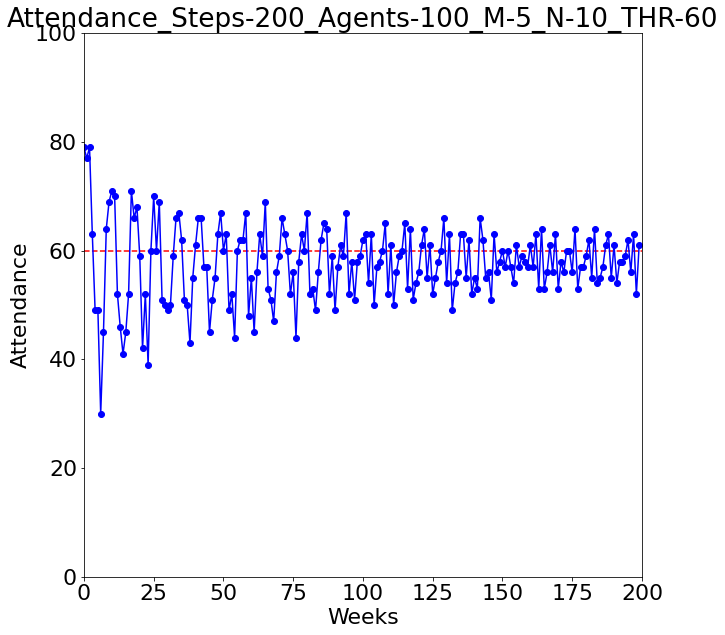

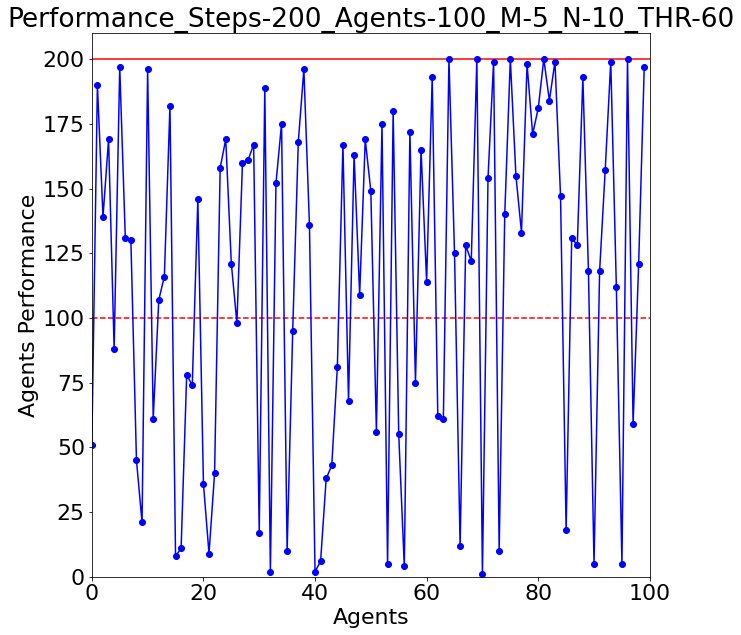

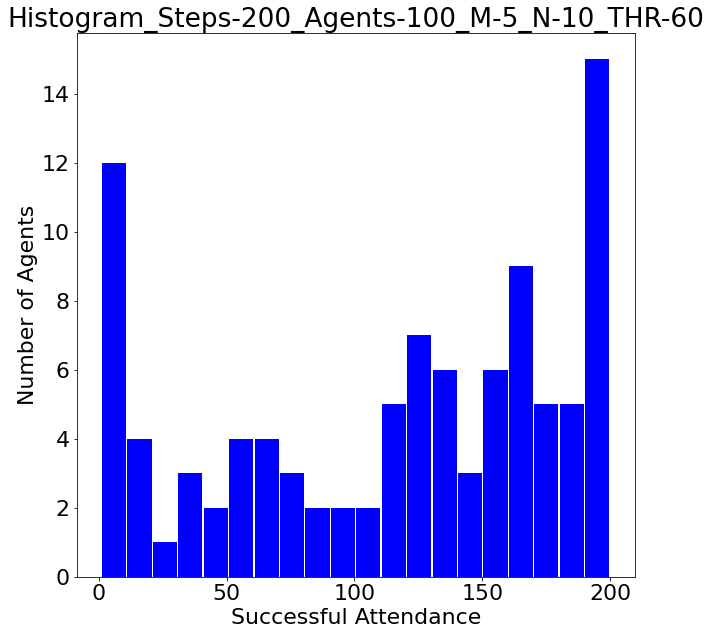

In [21]:
# Attendance numbers:
plt.figure(figsize=(10,10))
plt.plot(A_ts, 'b-o')
plt.xlabel('Weeks')
plt.ylabel('Attendance')
plt.xlim([0, NUM_STEPS])
plt.ylim([0, NUM_AGENTS])
plt.hlines(THRESHOLD, 0, NUM_STEPS, linestyles='dashed', colors='r')
filename = 'Attendance_Steps-' + str(NUM_STEPS) + '_Agents-' + str(NUM_AGENTS) + '_M-' + str(MEMORY) + '_N-' + str(NUM_STRATEGIES) + '_THR-' + str(THRESHOLD) + '.png'
plt.title(filename[:-4])
plt.savefig('./PLOTS/' + filename)
print("Average Attendance:", A_ts.mean())

# Agents' Performance:
plt.figure(figsize=(10,10))
plt.plot(agents_performance, 'b-o')
plt.xlabel('Agents')
plt.ylabel('Agents Performance')
plt.xlim([0, NUM_AGENTS])
plt.ylim([0, NUM_STEPS+10])
plt.hlines(NUM_STEPS/2, 0, NUM_STEPS, linestyles='dashed', colors='r')
plt.hlines(NUM_STEPS, 0, NUM_STEPS, linestyles='solid', colors='r')

filename = 'Performance_Steps-' + str(NUM_STEPS) + '_Agents-' + str(NUM_AGENTS) + '_M-' + str(MEMORY) + '_N-' + str(NUM_STRATEGIES) + '_THR-' + str(THRESHOLD) + '.png'
plt.title(filename[:-4])
plt.savefig('./PLOTS/' + filename)
print("Average Agent Performance:", agents_performance.mean())

# Agents' Performance Histogram:
plt.figure(figsize=(10,10))
plt.hist(agents_performance, bins= 20, rwidth=0.95 , color='b')
filename = 'Histogram_Steps-' + str(NUM_STEPS) + '_Agents-' + str(NUM_AGENTS) + '_M-' + str(MEMORY) + '_N-' + str(NUM_STRATEGIES) + '_THR-' + str(THRESHOLD) + '.png'
plt.title(filename[:-4])
plt.xlabel('Successful Attendance')
plt.ylabel('Number of Agents')
plt.savefig('./PLOTS/' + filename)